In [1]:
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype
from sklearn import tree, model_selection, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder


In [2]:
df = pd.read_csv("./Output/data_clean&processed_addedsentiment.csv")
print(df.shape)

(3419, 53)


In [3]:
df.head()

,id_row,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,...,num_faq_bool,avg_fund_per_backer,comments_afinn,blurb_name,faq_comments,story_afinn,faq_comments_afinn,blurb_name_afinn,blurb_afinn,name_afinn
0,0,1,With your help we will create this device that...,"{'id': 331, 'name': '3D Printing', 'slug': 'te...",1,ES,2015-08-18 21:01:19,USD,2016-07-09 20:11:23,1.212886,...,0,1.0,8.0,With your help we will create this device that...,[' ']AnaTalifi Wall Nazur\nabout 2 years ago...,-10.0,8.0,4.0,2.0,2.0
1,1,2,We at Ormiston Primary are looking at starting...,"{'id': 309, 'name': 'Farms', 'slug': 'food/far...",9,NZ,2015-08-11 18:04:21,USD,2015-09-11 15:55:41,0.723585,...,0,7.5,-1.0,We at Ormiston Primary are looking at starting...,[' ']No comments yet.,-10.0,-1.0,1.0,1.0,0.0
2,2,0,Self-taught aspiring metalsmith Looking for he...,"{'id': 54, 'name': 'Mixed Media', 'slug': 'art...",0,US,2015-04-28 21:14:03,USD,2015-05-28 21:14:00,1.000000,...,0,0.0,7.0,Self-taught aspiring metalsmith Looking for he...,[' ']Bambi Lewis\nover 7 years ago\nBeautifu...,-10.0,7.0,4.0,2.0,2.0
3,3,0,So many women believe they are past their prim...,"{'id': 278, 'name': 'People', 'slug': 'photogr...",0,US,2014-07-07 01:30:52,USD,2014-10-26 00:00:48,1.000000,...,0,0.0,139.0,So many women believe they are past their prim...,[' ']paul wheatonCreator\nover 2 years ago\n...,-10.0,139.0,3.0,0.0,3.0
4,4,10,The Horror Zine's Jeani Rector brings us anoth...,"{'id': 324, 'name': 'Anthologies', 'slug': 'pu...",340,US,2014-11-04 16:30:58,USD,2014-12-09 09:20:35,1.000000,...,0,34.0,-1.0,The Horror Zine's Jeani Rector brings us anoth...,[' ']No comments yet.,-10.0,-1.0,4.0,4.0,0.0


In [4]:
df.columns

Index(['id_row', 'backers_count', 'blurb', 'category',
       'converted_pledged_amount', 'country', 'created_at', 'current_currency',
       'deadline', 'fx_rate', 'goal', 'id', 'launched_at', 'location', 'name',
       'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'staff_pick',
       'state', 'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type', 'story', 'faq', 'num_faq', 'comments', 'n_comments',
       'duration', 'parent_category', 'category_name', 'location_name',
       'month_launched', 'year_launched', 'backers_count_log', 'goal_log',
       'pledged_log', 'duration_log', 'n_comments_log', 'num_faq_bool',
       'avg_fund_per_backer', 'comments_afinn', 'blurb_name', 'faq_comments',
       'story_afinn', 'faq_comments_afinn', 'blurb_name_afinn', 'blurb_afinn',
       'name_afinn'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3419 entries, 0 to 3418
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_row                    3419 non-null   int64  
 1   backers_count             3419 non-null   int64  
 2   blurb                     3419 non-null   object 
 3   category                  3419 non-null   object 
 4   converted_pledged_amount  3419 non-null   int64  
 5   country                   3419 non-null   object 
 6   created_at                3419 non-null   object 
 7   current_currency          3419 non-null   object 
 8   deadline                  3419 non-null   object 
 9   fx_rate                   3419 non-null   float64
 10  goal                      3419 non-null   int64  
 11  id                        3419 non-null   int64  
 12  launched_at               3419 non-null   object 
 13  location                  3419 non-null   object 
 14  name    

In [90]:
# Cols for OHE 
categorical_cols = ['country', 'staff_pick', 'usd_type', 'parent_category', 'category_name', 'location_name']

# Other feature cols for modelling
cols_to_keep = ['backers_count', 'fx_rate', 'goal', 'pledged', 'n_comments', 'duration', 'month_launched', 'year_launched', 'avg_fund_per_backer', 'num_faq_bool']
sentiment_cols = ['comments_afinn', 'faq_comments_afinn', 'blurb_name_afinn', 'blurb_afinn', 'name_afinn', 'story_afinn']
target_col = ['state']

#Cols to drop
text_cols = ['blurb', 'name', 'story', 'faq', 'comments', 'blurb_name', 'faq_comments']
log_cols = ['backers_count_log', 'goal_log', 'pledged_log', 'duration_log', 'n_comments_log']
other_cols = ['profile', 'category', 'created_at', 'location', 'current_currency', 'deadline', 'id', 
              'launched_at', 'slug', 'source_url', 'state_changed_at', 'urls', 'static_usd_rate', 
              'usd_pledged', 'converted_pledged_amount', 'spotlight', 'num_faq']

In [91]:
cols_to_drop = text_cols + log_cols + other_cols
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

(3419, 24)


In [92]:
# Split dataset
X = df.drop('state', axis=1)
y = df.state
#y.mean() #0.6370449678800857

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=2019)

In [93]:
# One Hot Encoding with training set only
OHE_df = pd.DataFrame()

for i in categorical_cols:
    OHE_df[i] = X_train[i].astype(CategoricalDtype(list(set(X[i]))))
    
    OHE_df = pd.concat([OHE_df, pd.get_dummies(X[i], prefix=i)],axis=1)

In [94]:
OHE_df = OHE_df.drop(categorical_cols, axis= 1)

X_no_cat = X.drop(categorical_cols, axis= 1)
OHE_df = pd.concat([X_no_cat, OHE_df],axis=1)

# For Decision Tree/Random Forest
OHE_df = OHE_df.drop(OHE_df.loc[:, OHE_df.columns.str.contains('_log')].columns.tolist(), axis=1)

In [95]:
# Resplit X dataset with OHE columns
OHE_train, OHE_test, y_train, y_test = model_selection.train_test_split(OHE_df, y, test_size=0.2, random_state=2019)

In [96]:
print('Before OHE, n features = ', X_train.shape[1])
print('After OHE, n features = ', OHE_train.shape[1])

Before OHE, n features =  23
After OHE, n features =  1322


# Hyperparameter tuning

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [98]:
#Benchmark for RF
model = RandomForestClassifier(random_state = 42)
model.fit(OHE_train, y_train)
y_predict_class = model.predict(OHE_test)
model_accuracy_score = accuracy_score(y_test, y_predict_class)

print("model_accuracy_score: ", model_accuracy_score)

model_accuracy_score:  0.9239766081871345


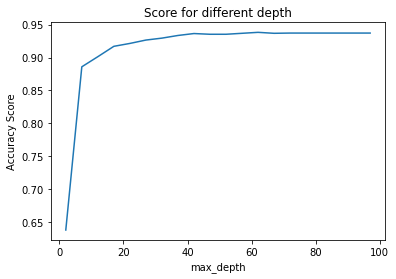

Best max_depth: {'max_depth': 62}
Best score: 0.9382048608325981


In [99]:
#Max Depth

dt_class = RandomForestClassifier(criterion = 'gini', random_state = 42)
max_depth = list(range(2,100,5))
param_grid = {'max_depth' : max_depth}
grid_dt_class = GridSearchCV(estimator = dt_class, param_grid = param_grid, scoring = 'accuracy', n_jobs = -1, cv = 10, refit = True, return_train_score = True)

grid_dt_class.fit(OHE_train, y_train)

score = grid_dt_class.cv_results_['mean_test_score']

plt.plot(max_depth, score)

# Add labels and title
plt.gca().set(xlabel='max_depth', ylabel='Accuracy Score',
title='Score for different depth')
plt.show()

print("Best max_depth:", grid_dt_class.best_params_)
print("Best score:", grid_dt_class.best_score_)

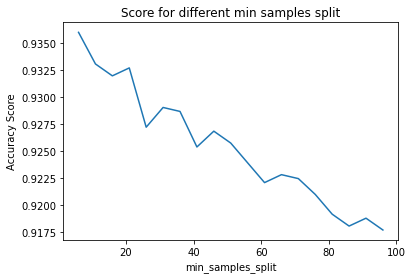

Best min_samples_split: {'min_samples_split': 6}
Best score: 0.9360070586347959


In [100]:
#Min samples split

dt_class = RandomForestClassifier(criterion = 'gini', random_state = 42)
min_samples_split = list(range(1, 100, 5))

param_grid = {'min_samples_split' : min_samples_split}
grid_dt_class = GridSearchCV(estimator = dt_class, param_grid = param_grid, scoring = 'accuracy', n_jobs = -1, cv = 10, refit = True, return_train_score = True)

grid_dt_class.fit(OHE_train, y_train)

score = grid_dt_class.cv_results_['mean_test_score']

plt.plot(min_samples_split, score)

# Add labels and title
plt.gca().set(xlabel='min_samples_split', ylabel='Accuracy Score',
title='Score for different min samples split')
plt.show()

print("Best min_samples_split:", grid_dt_class.best_params_)
print("Best score:", grid_dt_class.best_score_)

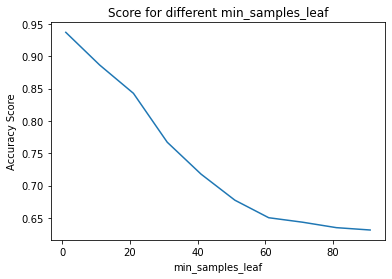

Best min_sample_leaf: {'min_samples_leaf': 1}
Best score: 0.9371072965963478


In [101]:
#Min sample leaf

dt_class = RandomForestClassifier(criterion = 'gini', random_state = 42)
min_samples_leaf = list(range(1,100,10))

param_grid = {'min_samples_leaf' : min_samples_leaf}
grid_dt_class = GridSearchCV(estimator = dt_class, param_grid = param_grid, scoring = 'accuracy', n_jobs = -1, cv = 10, refit = True, return_train_score = True)

grid_dt_class.fit(OHE_train, y_train)

score = grid_dt_class.cv_results_['mean_test_score']

plt.plot(min_samples_leaf, score)

# Add labels and title
plt.gca().set(xlabel='min_samples_leaf', ylabel='Accuracy Score',
title='Score for different min_samples_leaf')
plt.show()

print("Best min_sample_leaf:", grid_dt_class.best_params_)
print("Best score:", grid_dt_class.best_score_)

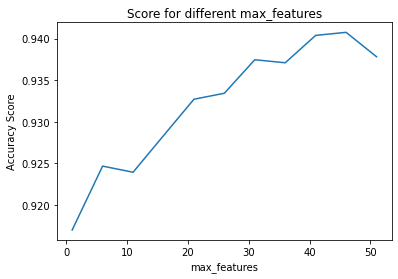

Best max_features: {'max_features': 46}
Best score: 0.9407689633967007


In [102]:
#Max features

dt_class = RandomForestClassifier(criterion='gini', random_state = 42)
max_features = list(range(1,55,5))

param_grid = {'max_features': max_features}
grid_dt_class = GridSearchCV(estimator = dt_class, param_grid = param_grid, scoring='accuracy', n_jobs=-1, cv = 10, refit=True, return_train_score=True)

grid_dt_class.fit(OHE_train, y_train)

score = grid_dt_class.cv_results_["mean_test_score"]

plt.plot(max_features, score)

# Add labels and title
plt.gca().set(xlabel='max_features', ylabel='Accuracy Score',
title='Score for different max_features')
plt.show()

print("Best max_features:", grid_dt_class.best_params_)
print("Best score:", grid_dt_class.best_score_)

In [103]:
#Set max depth 20,40,50,60,70,80
#Set min_samples_split 2,4,6,8 
#Set min_sample_leaf 1,3,5
#Set n_estimators

In [104]:
criterion = ['gini', 'entropy']
max_depth = [20,40,50,60,70,80]
min_samples_split = [2,4,6,8]
min_samples_leaf = [1,3,5]
max_features = [40,42,44,46,48,50]

param_grid = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features}
dt_class = RandomForestClassifier(n_estimators=100, random_state = 42, criterion = 'gini')
grid_dt_class = RandomizedSearchCV(estimator = dt_class, param_distributions = param_grid, scoring='accuracy', n_jobs=-1, cv = 10, refit=True, return_train_score=True, random_state=42)

grid_dt_class.fit(OHE_train, y_train)

print(grid_dt_class.best_params_)
print("Model score: ", grid_dt_class.best_score_)

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 40, 'max_depth': 70, 'criterion': 'entropy'}
Model score:  0.9458824630357479


In [105]:
#Find val score AUC using best model
criterion=['entropy']
max_depth = [70]
min_samples_split = [2]
min_samples_leaf = [1]
max_features = [40]

param_grid = {'criterion':criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features}
dt_class = RandomForestClassifier(n_estimators=100, random_state = 42, criterion = 'gini')
grid_dt_class = GridSearchCV(estimator = dt_class, param_grid = param_grid, scoring='accuracy', n_jobs=-1, cv = 10, refit=True, return_train_score=True)

grid_dt_class.fit(OHE_train, y_train)

model_rf = grid_dt_class.best_estimator_ 
y_predict_class = model_rf.predict(OHE_test)
model_accuracy_score = accuracy_score(y_test, y_predict_class)

print("model_accuracy_score: ",model_accuracy_score)

model_accuracy_score:  0.9254385964912281


# GridSearch

In [78]:
# from sklearn.ensemble import RandomForestClassifier
# classifier = RandomForestClassifier()
# classifier.get_params().keys()

In [79]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [4, 5, 6, 7],
#     'min_samples_split': [2, 8, 10, 12],
#     'n_estimators': [100, 200, 300, 500]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

# # Fit the grid search to the data
# grid_search.fit(OHE_train, y_train)
# grid_search.best_params_

# Random Forest

In [106]:
from numpy import *
random.seed(4222)
classifier = RandomForestClassifier(min_samples_split=2, max_features=40, max_depth=70, criterion='entropy')
#{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 40, 'max_depth': 70, 'criterion': 'entropy'}

In [107]:
print(OHE_train.shape)
print(y_train.shape)
print(OHE_test.shape)
print(y_test.shape)

(2735, 1322)
(2735,)
(684, 1322)
(684,)


In [108]:
classifier.fit(OHE_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=70, max_features=40)

# Model Evaluation

In [109]:
# Evaluate Model 
y_predict_class = classifier.predict(OHE_test)

report = """
The evaluation report is:
Confusion Matrix:
{}
Accuracy: {}
""".format(confusion_matrix(y_test, y_predict_class),
           accuracy_score(y_test, y_predict_class))
print(report)


The evaluation report is:
Confusion Matrix:
[[221  37]
 [ 14 412]]
Accuracy: 0.9254385964912281



# Feature Importance

In [110]:
important_features_dict = {}
importance = classifier.feature_importances_
for i, v in enumerate(importance):
    important_features_dict[i] = v

top_idx = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)[:10]

top_features_names = OHE_train.columns[top_idx]
top_features_scores = importance[top_idx]

print('Top 3 most important features: \n')

for i in range(3):
    print('%s: %s, Score: %.3f ' % (i+1, top_features_names[i], top_features_scores[i]))


Top 3 most important features: 

1: backers_count, Score: 0.211 
2: pledged, Score: 0.182 
3: avg_fund_per_backer, Score: 0.098 
